#**Titanic Survival Prediction**

## 1. Data Loading

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the built-in Titanic database from seaborn
df = sns.load_dataset('titanic')

# Peek at the rows
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [3]:
# Check for missing values
df.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


## 2. Data Cleaning

Columns with missing values: Age, deck, embarked, embark_town

Notes:
- Deck has too much missing values (>50%) so it will be dropped since it can't be imputed.
- Embarked and embark_town represent the same concept, where embarked is the code, where embark_town is the full name of that code.

/tmp/ipython-input-2885007295.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='embarked', data=df, palette='Set2', ax=axes[2])


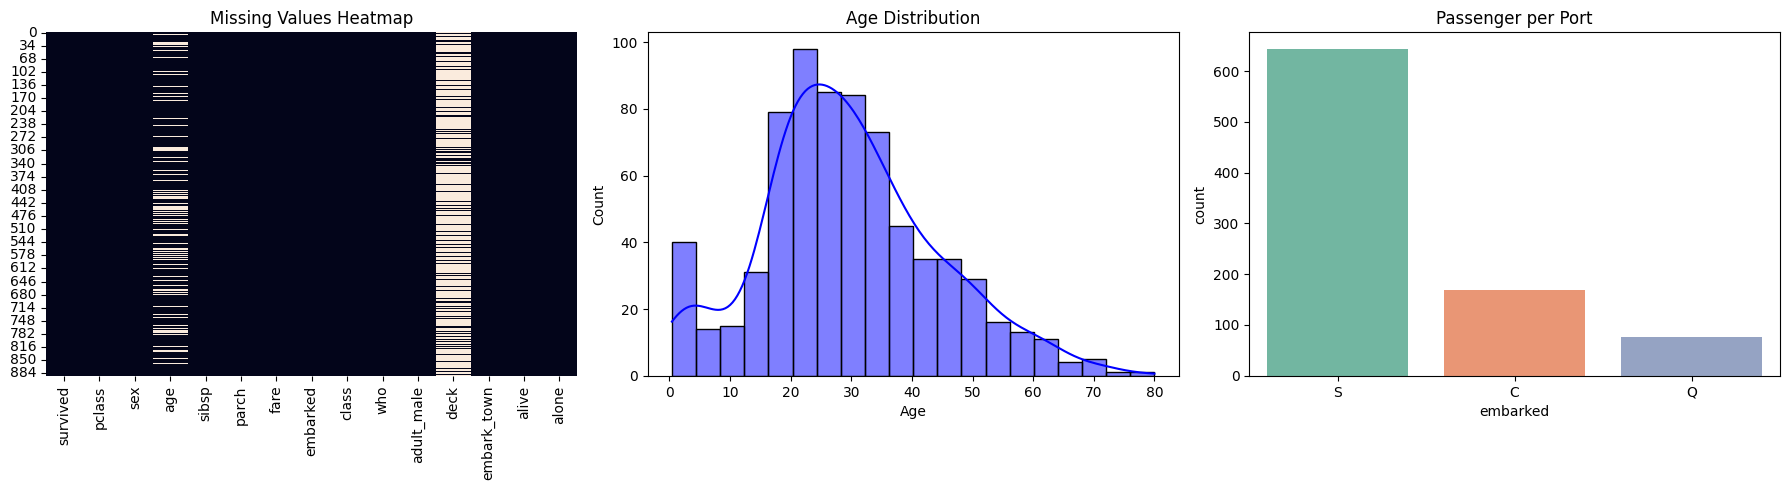

In [4]:
# Exploring the missing values
# Create 3 subplots to each 3 different values (age, deck, embarked-embark_town)
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# 1. Missing value heatmap
sns.heatmap(df.isnull(), cbar=False, ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# 2. Age distribution
# To find the age trend within the data
sns.histplot(df['age'].dropna(), kde=True, color='blue', ax=axes[1])
axes[1].set_title('Age Distribution')
axes[1].set_xlabel('Age')

# 3. Embarked count
# Show which embark port is the most common
sns.countplot(x='embarked', data=df, palette='Set2', ax=axes[2])
axes[2].set_title('Passenger per Port')

plt.tight_layout()
plt.show()

**Results**
1. Missing Values Heatmap:
  - 'Deck' column is predominantly empty (>50%). The missing values can't be imputed due to the high amount, so the column will be dropped.

2. Age Distribution:
  - Data is right-skewed (positive). To avoid bias, the data imputation will be using the median instead of the mean.

3. Passenger per Port:
  - Large majority of the data is S. Since the data is categorical, the imputation will use the mode.

In [5]:
# Handle each column with missing values

# 1. Drop the 'Deck' column
df.drop('deck', axis=1, inplace=True)

# 2. Drop the 'Embark_town' column
# This column is redundant due to the 'embarked' column
df.drop('embark_town', axis=1, inplace=True)

# 3. Fill the missing values in the 'age' column with the Median
age_median = df['age'].median()
df['age'].fillna(age_median, inplace=True)

# 4. Fill the missing values in the 'embarked' column with the Mode
embarked_mode = df['embarked'].mode()[0]
df['embarked'].fillna(embarked_mode, inplace=True)

# Verify
print("Remaining Missing Values: ")
print(df.isnull().sum())

Remaining Missing Values: 
survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
class         0
who           0
adult_male    0
alive         0
alone         0
dtype: int64


/tmp/ipython-input-1619794703.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(age_median, inplace=True)
/tmp/ipython-input-1619794703.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

## 3. Data Pre-Processing

### Encoding

In [6]:
# 1. 'Sex' column
# Use Binary Encoding because there are only two possible results (male, female)
df['sex'] = df['sex'].map({'male': 0, 'female': 1})

# 2. 'Embarked' column
# There are 3 possible results (S, C, Q), so we use One-Hot Encoding
embarked_dummies = pd.get_dummies(df['embarked'], prefix='embark', drop_first=True)
df = pd.concat([df, embarked_dummies], axis=1)

### Pruning
Columns that will be dropped:
- **embarked**: Redundant. This column is already encoded.
- **alive**: Redundant. The 'survived' column already describes this data.
- **class**: Redundant. The 'pclass' column already describes this data.
- **who**: Redundant. The 'sex' and 'age' columns already describes this data.
- **adult_male**: Redundant. The 'sex' and 'age' columns already describes this data.

In [7]:
cols_to_drop = ['embarked', 'class', 'who', 'adult_male', 'alive']
df.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,alone,embark_Q,embark_S
0,0,3,0,22.0,1,0,7.2500,False,False,True
1,1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,1,26.0,0,0,7.9250,True,False,True
3,1,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,0,35.0,0,0,8.0500,True,False,True


## 4. Training

In [9]:
# Import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [10]:
# Define data
X = df.drop('survived', axis=1) # Training data, everything BUT the answer
y = df['survived']              # Test data, ONLY the answer

# Split the data
# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Create the Logistic Regression model
logmodel = LogisticRegression(max_iter=1000)

In [12]:
# Model training
logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [13]:
# Quick results check
predictions = logmodel.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy score: {accuracy *100:.2f}%")

Accuracy score: 79.89%


## 5. Evaluation

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Detailed report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



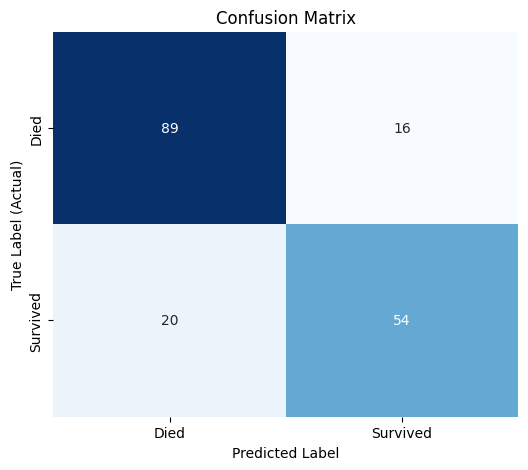

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label (Actual)')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['Died', 'Survived'])
plt.yticks([0.5, 1.5], ['Died', 'Survived'])
plt.show()

## Review

1. **True Positive** (54): *Correctly Predicted Survivors.*
- Most likely women and children in 1st or 2nd class which had the highest rescue priority.

2. **True Negative** (89): *Correctly Predicted Deaths.*
- Most likely men in 3rd class who didn't had the lowest rescue priority.

3. **False Positive** (16): *Optimistic Error.*
- Most likely women or other 1st class passengers who had high priority, but simply weren't lucky enough to escape or gave up their seats for others.

4. **False Negative** (20): *Pessimistic Error.*
- Most likely men or 3rd class passengers who got lucky enough to escape or fought their way through to a boat.

The model is slightly more likely to make a False Negative error (20) compared to a False Positive error (16). It can be considered "conservative", where it assumes death more often than it should.